# Exploring the Relationship Between the Meta Scores of Films and the Reviews of the General Audiance


## Introduction:
IMDB is an online database for films, television series, podcasts, and other media. This project will be working with movie data from IMDB. The data set of interest contains content data - including cast, production crew, plot summary, and scores. IMDB presents two kinds of scores; IMDB scores which are user-generated averages of reviews submitted to IMDB by the general audience, and Meta Scores which are critic-generated, representing the views of professionals who analyze films.

The goal of this project is to answer the following question:
"How accurate are the Meta Scores of films in predicting the reception of the general audience?"


The data set is from Kaggle, and includes data from the top 1000 movies based on the IMDB score. The data set includes the following columns:
* Series_Title: the name of the film
* Released_year: year it was released
* Certificate: certificate earned by the movie
* Runtime - total runtime
* Genre - list of genres the film falls into
* IMDB_Rating - the IMDB rating given by IMDB user reviews
* Overview - plot summary
* Meta_score - meta score of the movie determined by movie critics
* Director - name of the director of the movie
* Star1, Star2, Star3, Star4 - names of the stars of the movie in order of significance
* No_of_votes - number of reviews on IMDB
* Gross - how much money the movie earned

Dataset Origin: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

In [1]:
### Initialize libraries. 
library(tidyverse)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
### Reading from Github
url <- "https://github.com/anh-dong/dsci-100-2023w1-group-33/blob/main/data/imdb_top_1000.csv?raw=true"
movies <- read_csv(url) |>
    filter(Released_Year > 1970)

Rows: 1000 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Poster_Link, Series_Title, Released_Year, Certificate, Runtime, Ge...
dbl  (3): IMDB_Rating, Meta_score, No_of_Votes
num  (1): Gross

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
### Training data
set.seed(1234)

movies_training <- initial_split(movies, prop = 0.75, strata = Meta_score) |>
    training()

In [4]:
### Table Summary
movies <- movies_training |>
    select(Meta_score, IMDB_Rating, Released_Year) |>
    mutate(Meta_score = round(scale(Meta_score), 0), IMDB_Rating = round(scale(IMDB_Rating), 0))

movies_table_Meta_scores <- movies |>
    group_by(Meta_score) |>
    summarize(Meta_score_count = n()) |>
    rename(normalized_value = Meta_score)


movies_table_IMDB_Rating <- movies |>
    group_by(IMDB_Rating) |>
    summarize(IMDB_Rating_count = n()) |>
    rename(normalized_value = IMDB_Rating)

joined <- left_join(movies_table_Meta_scores, movies_table_IMDB_Rating) |>
    mutate(IMDB_Rating_count = replace(IMDB_Rating_count, is.na(IMDB_Rating_count), 0))
joined

Joining with `by = join_by(normalized_value)`


normalized_value,Meta_score_count,IMDB_Rating_count
"<dbl[,1]>",<int>,<dbl>
-4,2,0
-3,6,0
-2,30,0
-1,119,199
0,189,225
1,155,123
2,29,40
NA,67,0


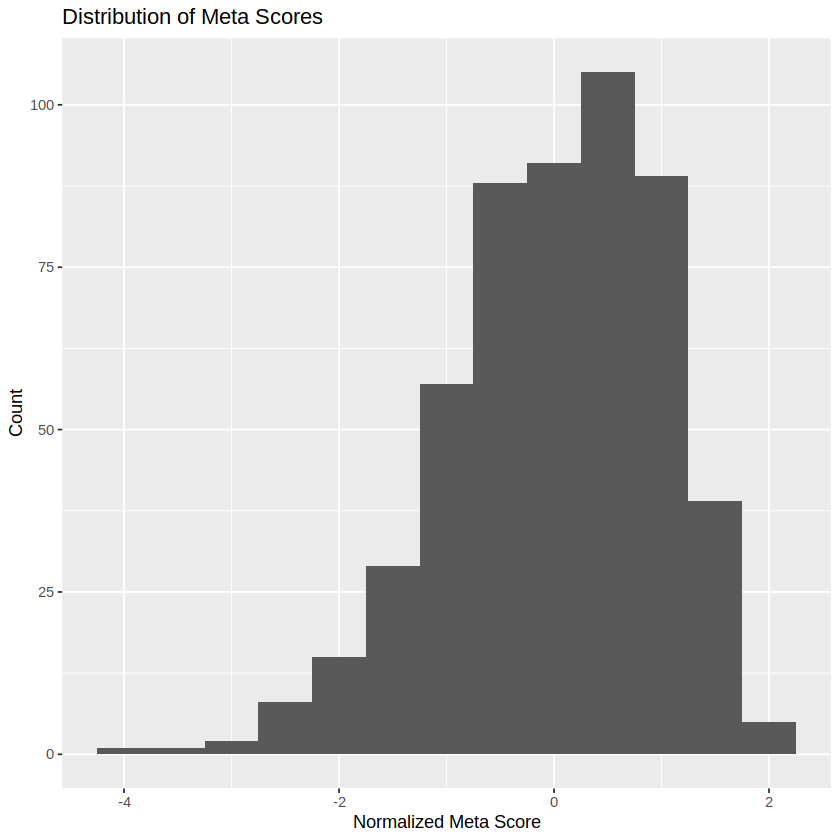

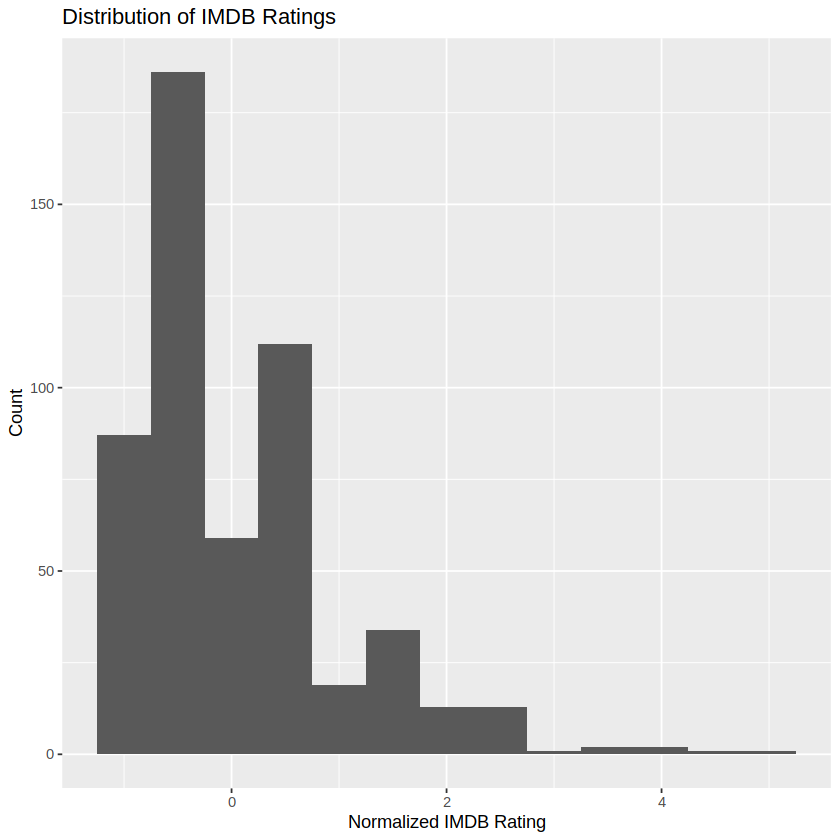

In [5]:
### Summary Visual
movies <- movies_training |>
    select(Meta_score, IMDB_Rating, Released_Year) |>
    filter(Released_Year > 1970) |>
    na.omit() |>
    mutate(Meta_score = scale(Meta_score), IMDB_Rating = scale(IMDB_Rating))

Meta_score_hist <- movies |>
    ggplot(aes(Meta_score)) +
        geom_histogram(binwidth = 0.5) +
        xlab("Normalized Meta Score") +
        ylab("Count") +
        ggtitle("Distribution of Meta Scores")
Meta_score_hist

IMDB_Review_hist <- movies |>
    ggplot(aes(IMDB_Rating)) +
        geom_histogram(binwidth = 0.5) +
        xlab("Normalized IMDB Rating") +
        ylab("Count") +
        ggtitle("Distribution of IMDB Ratings")
IMDB_Review_hist

## Methods:
The data will first be prepared by filtering for films released after 1970 and removing films without values in the Meta_score column. The relationship will be determined with a training data set containing 75% of the films a k-nn regression model using Meta_scores as the predictive variable and IMDB_Rating as the response variable. The k value will be determined through a tuning process to produce the minimal error between the training data set and the testing data set containing the films not found in the training data set. The error in the regression produced will give an indication on how strong the relationship is between the two variables. 

To visualize the result the scatter plot will be overlaid with a line produced by the regression to show whether the data is positively or negatively correlated and how much spread there is from the line and the data points.

## Expected Outcomes and Significance:
It is expected that the Meta Scores and audience reception will have a weak positive relationship. Critics are trying to give audiences an accurate expectation on the film based on their ratings so they should correlate positively with each other. However, critics and general audiences often look for different things in their ratings, producing more variability between the two ratings, potentially causing a weaker relationship. This relationship will allow audiences to understand how a meta score should factor into their decision to see a movie before any general audience ratings are available.